In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
df = pd.read_csv('ds//report_cleaned_dataset.csv', sep='\t')
del df['Unnamed: 0'] #drop the id column
#df = pd.read_csv('../dataset/customer_supermarket.csv', sep='\t', index_col=0)
dim1 = df.shape[0]
print('The dataset contains', dim1, 'records')
df = df.drop_duplicates()
dim2 = df.shape[0]
print('After deleting the duplicates record there are', dim2, 'entries, for a total of', dim1 - dim2, 'duplicate records')
df

The dataset contains 373364 records
After deleting the duplicates record there are 373364 entries, for a total of 0 duplicate records


,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,DayTime,TotalPrice,Week
0,539993,2011-04-01 10:00:00,1.95,13313.0,United Kingdom,22386,JUMBO BAG PINK POLKADOT,10,Morning,19.50,13
1,539993,2011-04-01 10:00:00,0.42,13313.0,United Kingdom,21499,BLUE POLKADOT WRAP,25,Morning,10.50,13
2,539993,2011-04-01 10:00:00,0.42,13313.0,United Kingdom,21498,RED RETROSPOT WRAP,25,Morning,10.50,13
3,539993,2011-04-01 10:00:00,2.10,13313.0,United Kingdom,22379,RECYCLING BAG RETROSPOT,5,Morning,10.50,13
4,539993,2011-04-01 10:00:00,1.25,13313.0,United Kingdom,20718,RED RETROSPOT SHOPPER BAG,10,Morning,12.50,13
...,...,...,...,...,...,...,...,...,...,...,...
373359,581587,2011-09-12 12:50:00,0.85,12680.0,France,22613,PACK OF SPACEBOY NAPKINS,12,Morning,10.20,37
373360,581587,2011-09-12 12:50:00,2.10,12680.0,France,22899,CHILDRENS APRON DOLLY GIRL,6,Morning,12.60,37
373361,581587,2011-09-12 12:50:00,4.15,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4,Morning,16.60,37
373362,581587,2011-09-12 12:50:00,4.15,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,Morning,16.60,37


In [4]:
df2 = df

# Good BasketID and ProdID

In [5]:
def good_bid(val):
    # Returns True is val is a good BasketID (i.e. six digit code), else False
    if len(val) == 6:
        if val.isnumeric():
            return True
    return False

In [6]:
def good_pid(val):
    if len(val) >= 5:
        if val[0:5].isnumeric():
            return True
    return False

# Discretization Qta

In [7]:
df2['QtaLabel'] = pd.cut(df2['Qta'].apply(np.abs), bins=[0, 1, 6, 12, 36, np.inf], labels=['Single', 'Small', 'Medium', 'High', 'Very High'])

# Discretization TotPrice

In [8]:
df2['TPLabel'] = pd.qcut(df2['TotalPrice'], 5, labels=[1, 2, 3, 4, 5])

# Extract customer information

In [9]:
customers = pd.DataFrame({'CustomerID': df2['CustomerID'].unique()})
customers = customers.astype({'CustomerID': 'object'})

### Add nationalities

In [10]:
dict_nats = {} # dictionary containing couple id: country 
groups = df2.groupby(df2['CustomerID']) # Group all the rows by CustomerID
for name, group in groups:
    basks = group['BasketID'].groupby(group['CustomerCountry']).unique() # For each customer, group the BasketID w.r.t. the country and count the number of unique values
    if basks.shape[0] > 1:
#PRINT  print('The customer ', str(name), ' made:', sep='')
        countries = basks.index.tolist() # Is this even necessary?
        maxm = 0
        mcountr = ''
        for country in countries:
            #TODO: consider also 'European Community' and 'Undefined'
            # Since the only cases where a customer have multiple nationalities don't include neither 'Unspecifies' and 'Eurpean Community', the code works anyway
            if maxm < basks[country].shape[0]:
                mcountr, maxm = country, basks[country].shape[0]
#PRINT      print('\t', basks[country].shape[0], ' purchase in ', country, sep='')
            # Choose the nationality with the greater number of purchase
#PRINT  print('\tmax: ', maxm, ', country: ', mcountr, sep='')
        countries.remove(mcountr)
#PRINT  print('\tlow countries: ', countries, sep='')
        df2.loc[df2['CustomerID'] == name, 'CustomerCountry'] = mcountr # NOT SURE! Maybe a better way
        dict_nats[name] = mcountr
    else:
        dict_nats[name] = basks.index[0]

In [11]:
customers['Country'] = customers['CustomerID'].map(dict_nats)

## CustomerID info: 
* Extract the number of baskets per customer
* Extract the number of bad baskets per customer
* Extract the number of purchased product
* Extract the number of product bought
* Extract the number of product returned
* Extract the money spent for each customer
* Extract the money refunded

In [12]:
print('There are', df2['BasketID'].unique().shape[0], 'distinct BasketID')
basks = df2.groupby(df2['CustomerID'])['BasketID'].nunique() # Total number of baskets (both good and bad)
bad_basks = df2.groupby(df2[~df2['BasketID'].apply(good_bid)]['CustomerID'])['BasketID'].nunique() # Total number of bad baskets
prods = df2.groupby(df2['CustomerID'])['ProdID'].nunique() # Number of different product bought
qtas = df2.groupby(df2[df2['BasketID'].apply(good_bid)]['CustomerID'])['Qta'].sum() # Total positive Qta
neg_qtas = df2.groupby(df2[~df2['BasketID'].apply(good_bid)]['CustomerID'])['Qta'].sum() # Total negative Qta
spent = df2.groupby(df2[df2['BasketID'].apply(good_bid)]['CustomerID'])['TotalPrice'].sum() # Total money spent
neg_spent = df2.groupby(df2[~df2['BasketID'].apply(good_bid)]['CustomerID'])['TotalPrice'].sum() # Total money refunded

customers['NumBaskets'] = customers['CustomerID'].map(basks)
customers['NumBadBasks'] = customers['CustomerID'].map(bad_basks)
customers['NumProd'] = customers['CustomerID'].map(prods)
customers['Qta'] = customers['CustomerID'].map(qtas)
customers['NegQta'] = customers['CustomerID'].map(neg_qtas)
customers['TotSpent'] = customers['CustomerID'].map(spent)
customers['TotNegSpent'] = customers['CustomerID'].map(neg_spent)
customers.fillna(value=0, axis=1, inplace=True)
customers

There are 20089 distinct BasketID


,CustomerID,Country,NumBaskets,NumBadBasks,NumProd,Qta,NegQta,TotSpent,TotNegSpent
0,13313.0,United Kingdom,5,0.0,47,851.0,0.0,1555.32,0.00
1,18097.0,United Kingdom,6,1.0,65,1406.0,-1.0,2479.88,-4.95
2,16656.0,United Kingdom,20,6.0,14,8498.0,-21.0,8197.04,-57.56
3,16875.0,United Kingdom,9,4.0,94,1069.0,-25.0,2095.53,-72.06
4,13094.0,United Kingdom,15,4.0,4,1524.0,-174.0,1703.64,-218.46
...,...,...,...,...,...,...,...,...,...
4226,13436.0,United Kingdom,1,0.0,12,76.0,0.0,196.89,0.00
4227,15520.0,United Kingdom,1,0.0,18,314.0,0.0,343.50,0.00
4228,13298.0,United Kingdom,1,0.0,2,96.0,0.0,360.00,0.00
4229,14569.0,United Kingdom,1,0.0,10,79.0,0.0,227.39,0.00


# Delete bad customers
* customers with only negative Qta

In [13]:
bad_customers = customers[customers['Qta'] < customers['NegQta'].apply(np.abs)]
customers.drop(index=bad_customers.index, inplace=True)

# Define ActualQta and ActualSpent

In [14]:
customers['ActualQta'] = customers['Qta'].add(customers['NegQta'])
customers['ActualSpent'] = customers['TotSpent'].add(customers['TotNegSpent'])

# Delete bad customers
* customers with ActualQta equal to zero

In [15]:
customers = customers[customers['ActualQta'] > 0]

In [16]:
customers['ActualSpent'].describe()

count      4199.000000
mean       1840.920181
std        7974.887515
min           2.900000
25%         297.865000
50%         642.800000
75%        1554.900000
max      270986.202755
Name: ActualSpent, dtype: float64

# Define new attributes
* avgPrice
* avgBasksValue

In [17]:
customers['AvgPrice'] = customers['ActualSpent'].divide(customers['ActualQta'])
customers['AvgBasksValue'] = customers['ActualSpent'].divide(customers['NumBaskets'].subtract(customers['NumBadBasks']))

<ipython-input-17-080e76452232>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['AvgPrice'] = customers['ActualSpent'].divide(customers['ActualQta'])
<ipython-input-17-080e76452232>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['AvgBasksValue'] = customers['ActualSpent'].divide(customers['NumBaskets'].subtract(customers['NumBadBasks']))


# Compute the entropy

In [18]:
entropy = {}
for cust, data in df2['QtaLabel'].groupby(df2['CustomerID']):
    entropy[cust] = 0
    tot = data.count()
    #print(cust)
    #print(tot)
    for label, count in data.value_counts().iteritems():
        if count == 0:
            continue
        p = count/tot
        entropy[cust] += -p*np.log2(p)
        #print('\t', f'{label:10}', f'{count:3}', '  ', '%.3f' %p, '%.3f' %entropy[cust], sep='')
    #print('Entropy: ', entropy[cust])
    
customers['QtaEntr'] = customers['CustomerID'].map(entropy)

<ipython-input-18-b7345adcaee8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['QtaEntr'] = customers['CustomerID'].map(entropy)


In [19]:
entropy = {}
for cust, data in df2['TPLabel'].groupby(df2['CustomerID']):
    entropy[cust] = 0
    tot = data.count()
    #print(cust)
    #print(tot)
    for label, count in data.value_counts().iteritems():
        if count == 0:
            continue
        p = count/tot
        entropy[cust] += -p*np.log2(p)
        #print('\t', f'{label:10}', f'{count:3}', '  ', '%.3f' %p, '%.3f' %entropy[cust], sep='')
    #print('Entropy: ', entropy[cust])
    
customers['TPEntr'] = customers['CustomerID'].map(entropy)

<ipython-input-19-574c21a5716e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['TPEntr'] = customers['CustomerID'].map(entropy)


In [20]:
from scipy.stats import entropy
entropy = df2.groupby('CustomerID')['TotalPrice'].apply(lambda x : entropy(x.value_counts(), base=2))
customers['E'] = customers['CustomerID'].map(entropy)
customers

<ipython-input-20-cc0e2b4c52e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['E'] = customers['CustomerID'].map(entropy)


,CustomerID,Country,NumBaskets,NumBadBasks,NumProd,Qta,NegQta,TotSpent,TotNegSpent,ActualQta,ActualSpent,AvgPrice,AvgBasksValue,QtaEntr,TPEntr,E
0,13313.0,United Kingdom,5,0.0,47,851.0,0.0,1555.32,0.00,851.0,1555.32,1.827638,311.064000,1.357501,1.511034,4.066998
1,18097.0,United Kingdom,6,1.0,65,1406.0,-1.0,2479.88,-4.95,1405.0,2474.93,1.761516,494.986000,1.804576,1.710616,4.997024
2,16656.0,United Kingdom,20,6.0,14,8498.0,-21.0,8197.04,-57.56,8477.0,8139.48,0.960184,581.391429,1.784300,0.902926,4.474662
3,16875.0,United Kingdom,9,4.0,94,1069.0,-25.0,2095.53,-72.06,1044.0,2023.47,1.938190,404.694000,1.659600,1.996238,5.279567
4,13094.0,United Kingdom,15,4.0,4,1524.0,-174.0,1703.64,-218.46,1350.0,1485.18,1.100133,135.016364,0.986427,0.764205,2.088221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226,13436.0,United Kingdom,1,0.0,12,76.0,0.0,196.89,0.00,76.0,196.89,2.590658,196.890000,1.418296,1.483356,3.418296
4227,15520.0,United Kingdom,1,0.0,18,314.0,0.0,343.50,0.00,314.0,343.50,1.093949,343.500000,0.614369,1.392147,2.996624
4228,13298.0,United Kingdom,1,0.0,2,96.0,0.0,360.00,0.00,96.0,360.00,3.750000,360.000000,1.000000,0.000000,1.000000
4229,14569.0,United Kingdom,1,0.0,10,79.0,0.0,227.39,0.00,79.0,227.39,2.878354,227.390000,1.625815,1.792481,3.418296


# Customer2

In [22]:
customers2 = customers.loc[:, ['CustomerID', 'ActualQta', 'ActualSpent', 'AvgPrice', 'AvgBasksValue', 'E']]
customers2['YearFreq'] = (customers['NumBaskets'].subtract(customers['NumBadBasks'])).divide(12)
customers2

,CustomerID,ActualQta,ActualSpent,AvgPrice,AvgBasksValue,E,YearFreq
0,13313.0,851.0,1555.32,1.827638,311.064000,4.066998,0.416667
1,18097.0,1405.0,2474.93,1.761516,494.986000,4.997024,0.416667
2,16656.0,8477.0,8139.48,0.960184,581.391429,4.474662,1.166667
3,16875.0,1044.0,2023.47,1.938190,404.694000,5.279567,0.416667
4,13094.0,1350.0,1485.18,1.100133,135.016364,2.088221,0.916667
...,...,...,...,...,...,...,...
4226,13436.0,76.0,196.89,2.590658,196.890000,3.418296,0.083333
4227,15520.0,314.0,343.50,1.093949,343.500000,2.996624,0.083333
4228,13298.0,96.0,360.00,3.750000,360.000000,1.000000,0.083333
4229,14569.0,79.0,227.39,2.878354,227.390000,3.418296,0.083333


# Get the logarithms

In [23]:
customers2['logQta'] = customers2['ActualQta'].apply(np.log10)
customers2['logSpent'] = customers2['ActualSpent'].apply(np.log10)
customers2.drop(columns=['ActualQta', 'ActualSpent'], inplace=True)
customers2['logAvgPrice'] = customers2['AvgPrice'].apply(np.log10)
customers2['logAvgBasksValue'] = customers2['AvgBasksValue'].apply(np.log10)
customers2.drop(columns=['AvgPrice', 'AvgBasksValue'], inplace=True)
customers2

,CustomerID,E,YearFreq,logQta,logSpent,logAvgPrice,logAvgBasksValue
0,13313.0,4.066998,0.416667,2.929930,3.191820,0.261890,2.492850
1,18097.0,4.997024,0.416667,3.147676,3.393563,0.245887,2.694593
2,16656.0,4.474662,1.166667,3.928242,3.910597,-0.017646,2.764469
3,16875.0,5.279567,0.416667,3.018700,3.306097,0.287396,2.607127
4,13094.0,2.088221,0.916667,3.130334,3.171779,0.041445,2.130386
...,...,...,...,...,...,...,...
4226,13436.0,3.418296,0.083333,1.880814,2.294224,0.413410,2.294224
4227,15520.0,2.996624,0.083333,2.496930,2.535927,0.038997,2.535927
4228,13298.0,1.000000,0.083333,1.982271,2.556303,0.574031,2.556303
4229,14569.0,3.418296,0.083333,1.897627,2.356771,0.459144,2.356771


# Clustering

# Get the data and Standardize

In [24]:
from sklearn.preprocessing import StandardScaler
columns = customers2.columns[1:]
X_data = customers2.iloc[:, 1:].to_numpy()
sc = StandardScaler()
X = sc.fit_transform(X_data)

# PCA

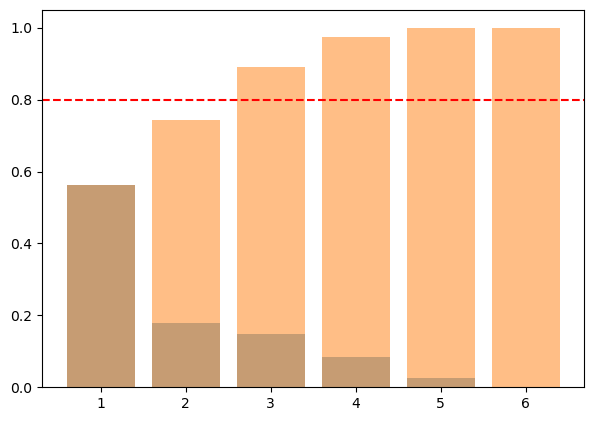

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
X = pca.fit_transform(X)
cumsum = [0]
i = 0
for val in pca.explained_variance_ratio_:
    cumsum.append(cumsum[i]+val)
    i += 1
plt.bar(range(1, X.shape[1] + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.bar(range(1, X.shape[1] + 1), cumsum[1:], alpha=0.5, align='center', label='Cumulative explained variance')
plt.axhline(0.8, color='red', linestyle='--')
plt.plot()
plt.savefig('pca.png')

In [26]:
pca = PCA(n_components=2)
X = pca.fit_transform(X)

# K-Means

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

it = 10
distorsions = []
sil_coef = []
for i in range(2, it):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    l = km.fit_predict(X)
    
    # distorsion
    distorsions.append(km.inertia_)
    
    # silhouette coefficient
    sil = silhouette_samples(X, l, metric='euclidean')
    sil_coef.append(np.mean(sil))
    
pdiff = []
for i in range(1, it-2):
    pdiff.append((distorsions[i-1] - distorsions[i])/distorsions[i-1])

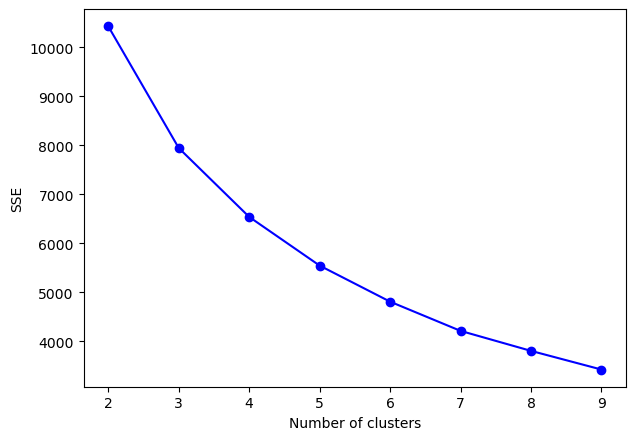

In [28]:
plt.plot(range(2, it), distorsions, marker='o', c='b')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.plot()
plt.savefig('sse.png')

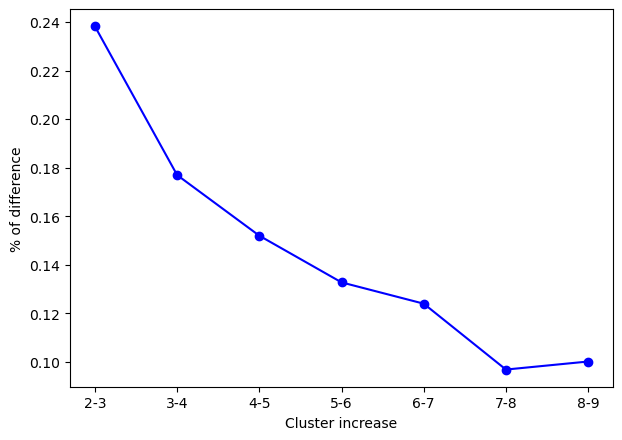

In [29]:
plt.plot(range(1, it-2), pdiff, marker='o', c='b')
plt.xlabel('Cluster increase')
plt.xticks(range(1, it-2), [str(i-1)+'-'+str(i) for i in range(3, it)])
plt.ylabel('% of difference')
plt.plot()
plt.savefig('perc.png')

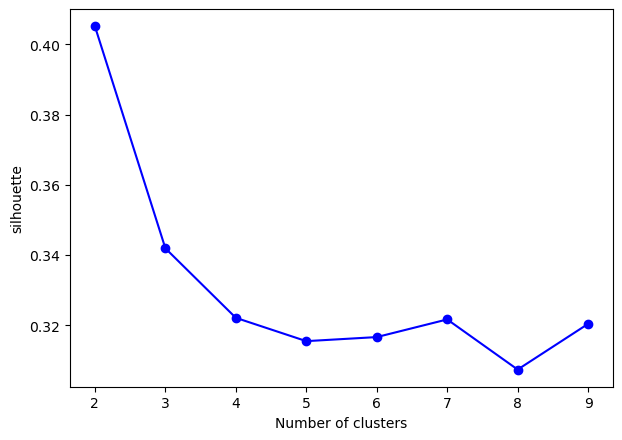

In [30]:
plt.plot(range(2, it), sil_coef, marker='o', c='b')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.plot()
plt.savefig('sil.png')

### Set K = 3, execute clustering

In [31]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
y_km = km.fit_predict(X)
customers2['KMeans_label'] = y_km

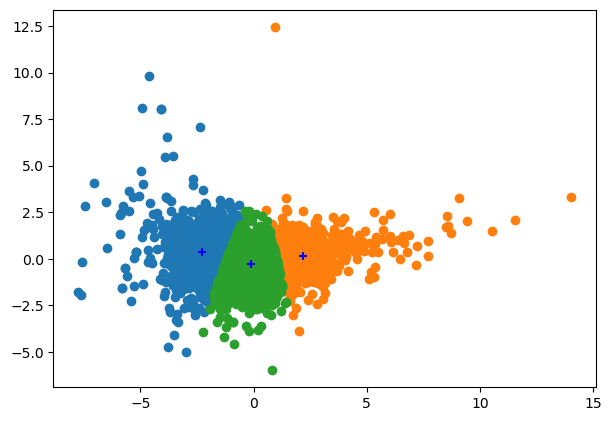

In [32]:
if X.shape[1] == 2:
    for i in np.unique(y_km):
        plt.scatter(X[y_km==i, 0], X[y_km==i, 1])
        plt.scatter(km.cluster_centers_[i, 0], km.cluster_centers_[i, 1], marker='+', c='b')
plt.savefig('km_clusters.png')

# K-Means clustering validation

Number of clusters: 3
Number of point per cluster:
	Cluster 0 points 990 (0.236)
	Cluster 1 points 1137 (0.271)
	Cluster 2 points 2072 (0.493)


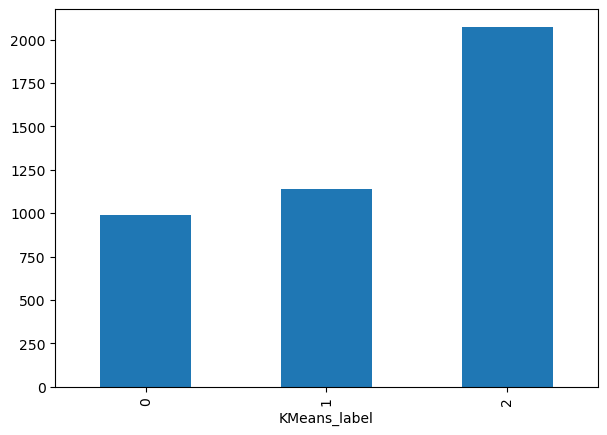

In [33]:
print('Number of clusters:', customers2['KMeans_label'].nunique())
print('Number of point per cluster:')
for i, data in customers2['KMeans_label'].groupby(customers2['KMeans_label']):
    perc = data.shape[0]/customers2.shape[0]
    print('\tCluster', i, 'points', data.shape[0], '(%.3f)' % perc)
customers2['KMeans_label'].groupby(customers2['KMeans_label']).count().plot(kind='bar')

### Silhouette

Cluster 0 avg silhouette: 0.24738153162077564
Cluster 1 avg silhouette: 0.37768853360779114
Cluster 2 avg silhouette: 0.36750222074489397
Total avg silhouette: 0.341939552369623


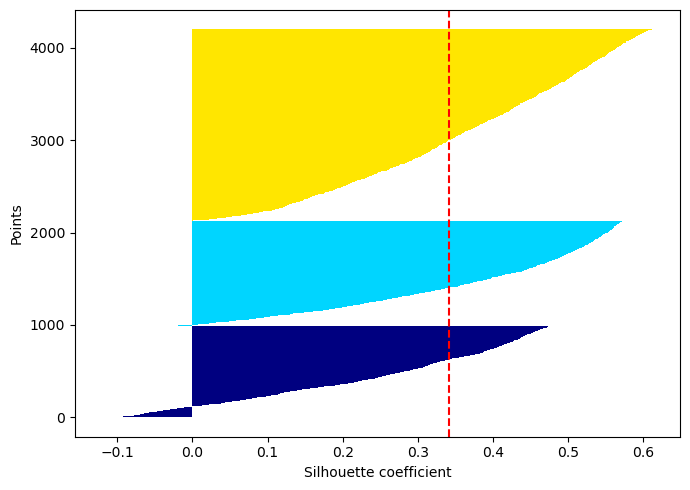

In [34]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km) # Get cluster labels
n_clusters = cluster_labels.shape[0] # Get number of clusters
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean') # Get the silhouette values

y_ax_lower, y_ax_upper = 0, 0
y_tick = []

for i, c in enumerate(cluster_labels):
    
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    
    print('Cluster', c, 'avg silhouette:', np.mean(c_silhouette_vals))
    
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    y_tick.append((y_ax_lower+y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
print('Total avg silhouette:', silhouette_avg)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks=(y_tick, cluster_labels+1)
plt.ylabel('Points')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.savefig('sil_tot.png')
plt.show()

### Similarity

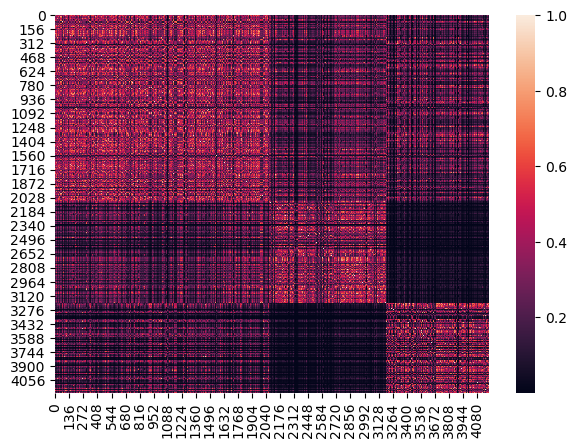

In [35]:
from sklearn.metrics.pairwise import euclidean_distances
customers2.sort_values(by='KMeans_label', ascending=False, inplace=True)
dist = euclidean_distances(customers2.loc[:, columns], customers2.loc[:, columns])
sim = np.exp(-dist)
sns_plot = sns.heatmap(sim)
figure = sns_plot.get_figure()    
figure.savefig('sim_heatmap.png', dpi=400)

### Look at the dataset

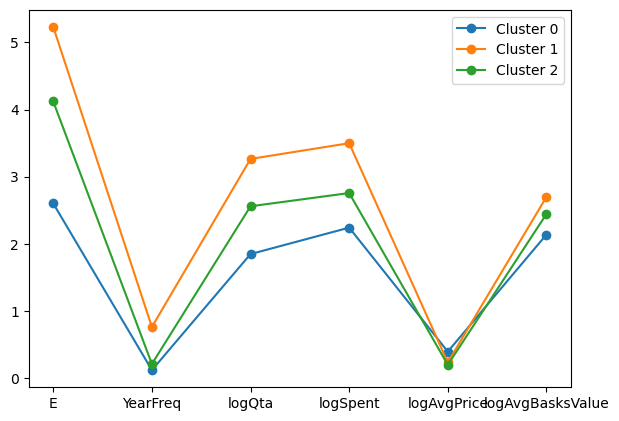

In [36]:
means = []
std = []

for i in np.unique(y_km):
    clust = customers2.loc[customers2['KMeans_label'] == i, columns]
    means.append(clust.describe().loc['mean'].values)
    std.append(clust.describe().loc['std'].values)
legend = []
for i in np.unique(y_km):
    plt.plot(range(0, columns.shape[0]), means[i], marker='o')
    legend.append('Cluster %d' %i)
plt.legend(legend)
plt.xticks(range(0, columns.shape[0]), columns)
plt.savefig('cluster_avg.png')
plt.show()

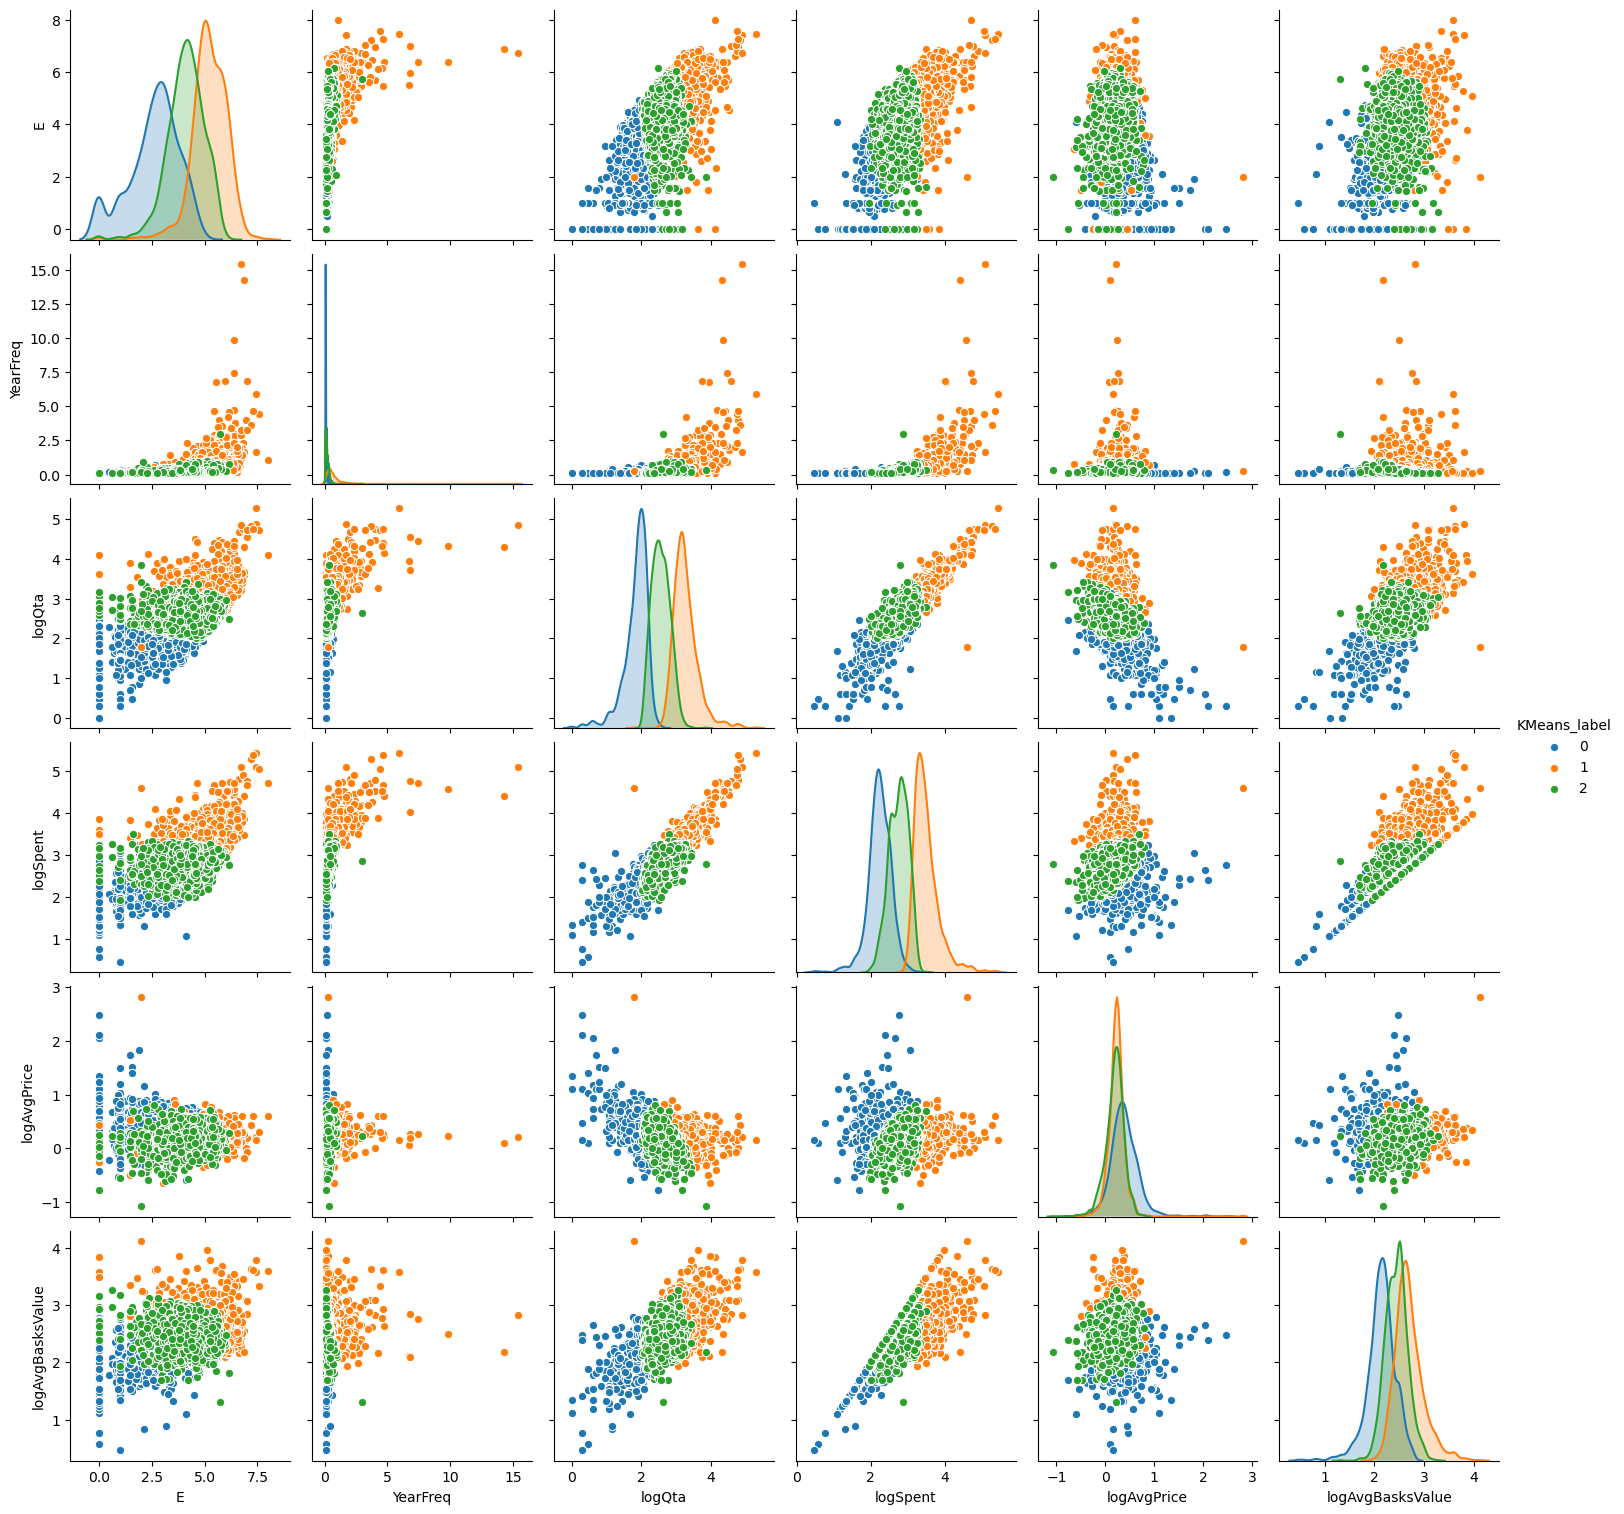

In [37]:
sns_plot = sns.pairplot(customers2, hue='KMeans_label', vars=columns)  
sns_plot.savefig('pair_plot_clust.png', dpi=400)

### Some useful plots

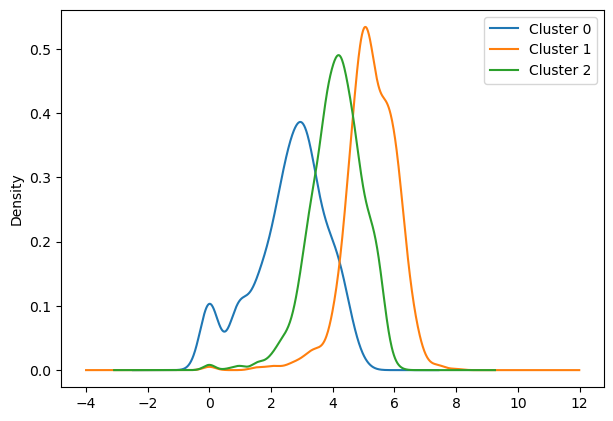

In [39]:
customers2[customers2['KMeans_label'] == 0]['E'].plot(kind='kde')
customers2[customers2['KMeans_label'] == 1]['E'].plot(kind='kde')
customers2[customers2['KMeans_label'] == 2]['E'].plot(kind='kde')
plt.legend(('Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.savefig('tp_entr_km.png')
plt.show()

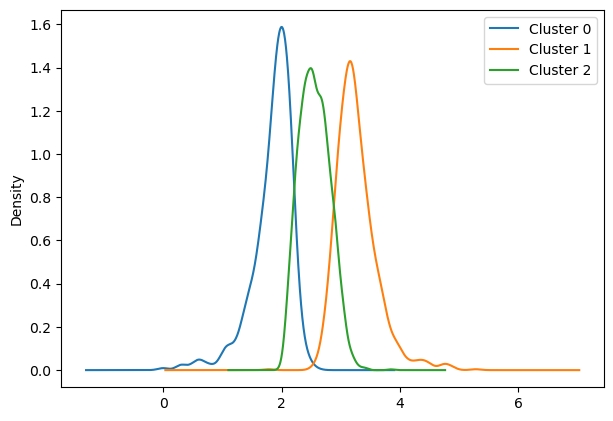

In [40]:
customers2[customers2['KMeans_label'] == 0]['logQta'].plot(kind='kde')
customers2[customers2['KMeans_label'] == 1]['logQta'].plot(kind='kde')
customers2[customers2['KMeans_label'] == 2]['logQta'].plot(kind='kde')
plt.legend(('Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.savefig('logqta_km.png')
plt.show()

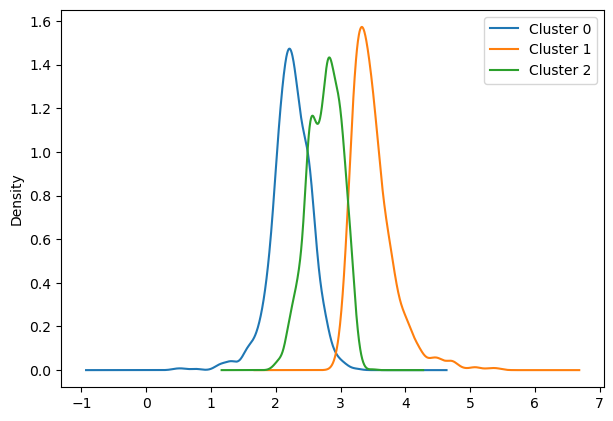

In [41]:
customers2[customers2['KMeans_label'] == 0]['logSpent'].plot(kind='kde')
customers2[customers2['KMeans_label'] == 1]['logSpent'].plot(kind='kde')
customers2[customers2['KMeans_label'] == 2]['logSpent'].plot(kind='kde')
plt.legend(('Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.savefig('logspent_km.png')
plt.show()

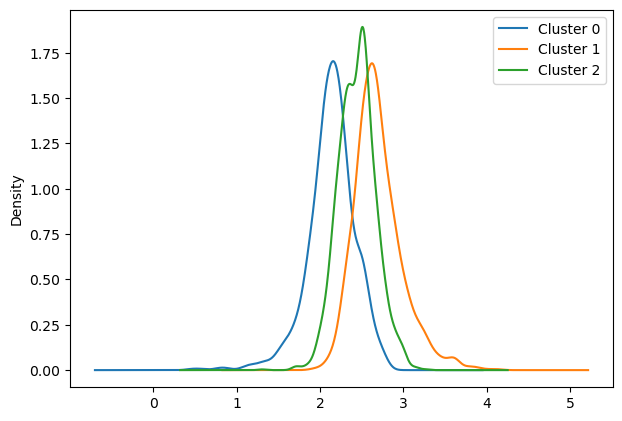

In [42]:
customers2[customers2['KMeans_label'] == 0]['logAvgBasksValue'].plot(kind='kde')
customers2[customers2['KMeans_label'] == 1]['logAvgBasksValue'].plot(kind='kde')
customers2[customers2['KMeans_label'] == 2]['logAvgBasksValue'].plot(kind='kde')
plt.legend(('Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.savefig('logavgbv_km.png')
plt.show()

# Hierarchical clustering

In [43]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# Ricorda! X è il risultato della PCA sul dataset originale.
dist = pdist(X, metric='euclidean') # Compute condensed distance matrix (a vector)

## Complete Link

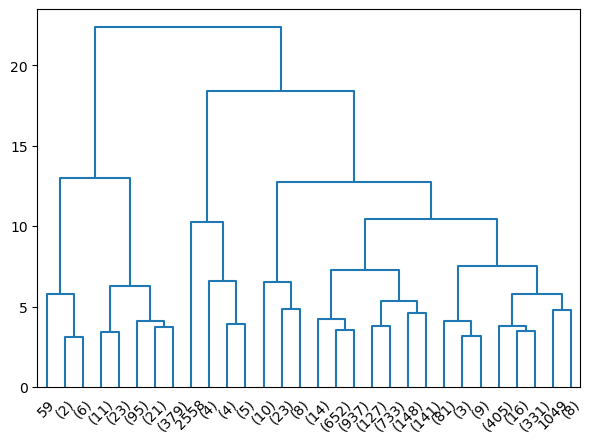

In [44]:
data_link_compl = linkage(dist, method='complete', metric='euclidean') 
df_compl = pd.DataFrame(data_link_compl, columns=['row label1', 'row label2', 'distance', 'no. of item in clust'], index=['cluster %d' %(i+1) for i in range(data_link_compl.shape[0])])
res_compl = dendrogram(data_link_compl, color_threshold=1.0, truncate_mode='lastp')
plt.savefig('c_link.png')

## Single Link

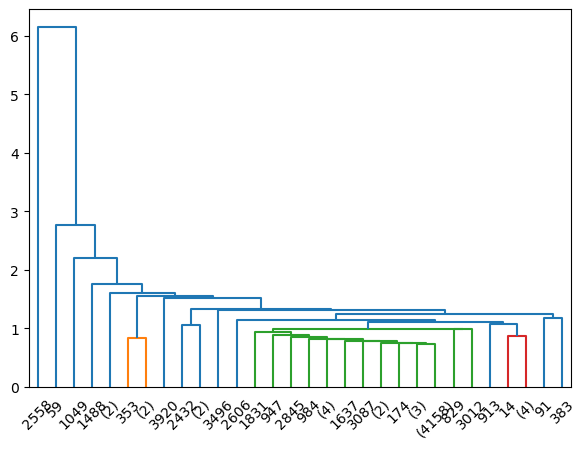

In [45]:
data_link_singl = linkage(dist, method='single', metric='euclidean') 
df_singl = pd.DataFrame(data_link_singl, columns=['row label1', 'row label2', 'distance', 'no. of item in clust'], index=['cluster %d' %(i+1) for i in range(data_link_singl.shape[0])])
res_singl = dendrogram(data_link_singl, color_threshold=1.0, truncate_mode='lastp')
plt.savefig('s_link.png')

## Ward

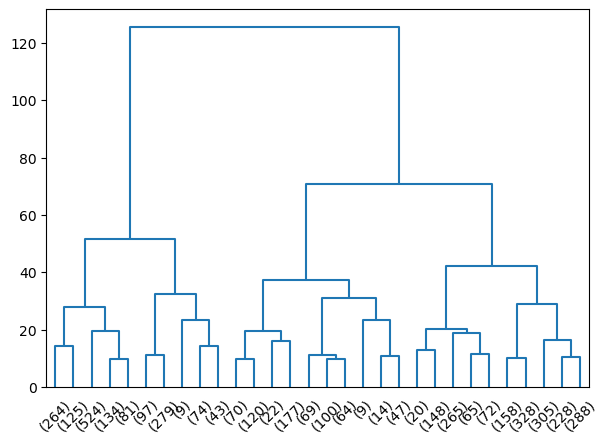

In [46]:
data_link_ward = linkage(dist, method='ward', metric='euclidean') 
df_ward = pd.DataFrame(data_link_ward, columns=['row label1', 'row label2', 'distance', 'no. of item in clust'], index=['cluster %d' %(i+1) for i in range(data_link_ward.shape[0])])
res_ward = dendrogram(data_link_ward, color_threshold=1.0, truncate_mode='lastp')
plt.savefig('ward.png')

## Centroid

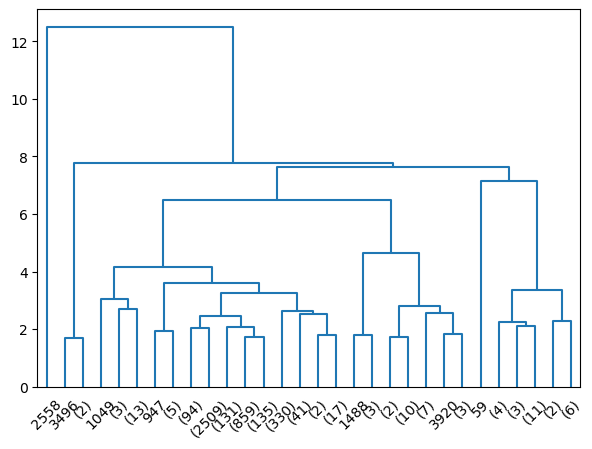

In [47]:
data_link_centr = linkage(dist, method='centroid', metric='euclidean') 
df_centr = pd.DataFrame(data_link_centr, columns=['row label1', 'row label2', 'distance', 'no. of item in clust'], index=['cluster %d' %(i+1) for i in range(data_link_centr.shape[0])])
res_centr = dendrogram(data_link_centr, color_threshold=1.0, truncate_mode='lastp')
plt.savefig('centroid.png')

In [48]:
from scipy.cluster.hierarchy import cophenet
cpcc = pd.DataFrame({'Technique': ['Complete Link',
                                   'Single Link', 
                                   'Ward', 
                                   'Centroid'], 
                     'CPCC': [cophenet(data_link_compl, dist)[0],
                              cophenet(data_link_singl, dist)[0], 
                              cophenet(data_link_ward, dist)[0],
                              cophenet(data_link_centr, dist)[0]]})
cpcc

,Technique,CPCC
0,Complete Link,0.510179
1,Single Link,0.619180
2,Ward,0.464028
3,Centroid,0.748298


# DBSCAN

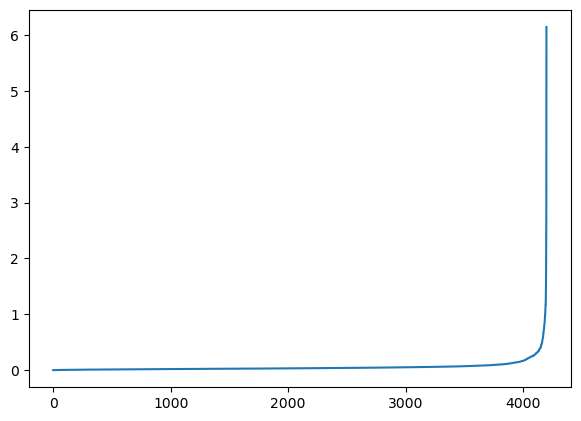

In [49]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=8)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


In [53]:
eps = 0.6
min_samples = 8
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
y_db = db.fit_predict(X)
customers2['DB_label'] = y_db

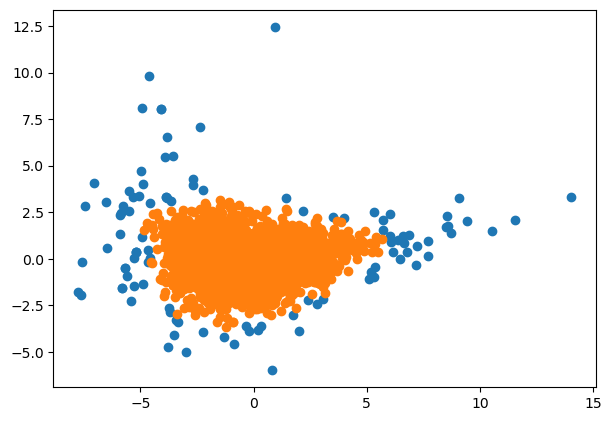

In [54]:
if X.shape[1] == 2:
    for i in np.unique(y_db):
        plt.scatter(X[y_db==i, 0], X[y_db==i, 1])
plt.savefig('dbscan.png')

### Bad

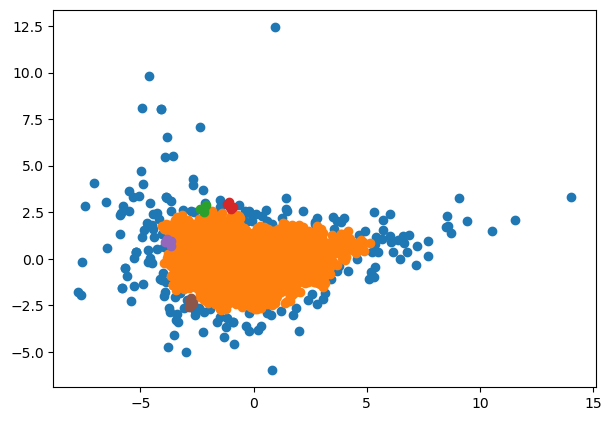

In [55]:
eps = 0.3
min_samples = 5
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
y_db = db.fit_predict(X)
if X.shape[1] == 2:
    for i in np.unique(y_db):
        plt.scatter(X[y_db==i, 0], X[y_db==i, 1])
plt.savefig('dbscan_bad.png')

In [56]:
np.unique(y_db)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

# Clustering conclusion
### Preprocessing
The data matrix was first standardized and then the two principal components were extracted. The choise was between two and tre principal component since they retain respectively ~0.65 and ~0.8 of the variance of the data. The choise was to extract just two components because it performed better of K-Means and in this way a visual inspection was possible.
### K-Means
The algorithm run for K rangind from two to ten clusters. For each iteration the SSE and the averange silhouette value were computed. By looking at the plot we can see that there isn't a prominent *elbow shape* so to get the optimal number of clusters the analisys of more metric was necessary. At first we saw that for K moving from two to three the difference of the SSE in percentage was quite high (~0.3) while for all the other values the difference was below the 0.2 meaning that the most of the decrease in the SSE was in moving from 2 to 3 clusters. By inspecting the silhouette score in it's possible to see that it has its maximum for K equal to two, followed by K equal to 3, for all the other values of K the silhouette score was low. In conclusion we opted of K equal to three to get a trade off between high silhouette and low SSE.

The resulting clusters have a comparable number of points. In particular the cluster zero has 1312 points, the cluster one 757 and the cluster two 2131. By looking at the plot of the Silhouette score we see that a small fraction of points in cluster one and two have a negative value but overall the Silhouette suggest a good clustering.

The similarity matrix shows that the points within the same cluster similar to each other when similarity is measure with $e^{-d(x, y)}$ where $x$ and $y$ are data points and $d$ is the euclidean distance. In particular the cluster 0 includes points really similar, and so is cluster 2. As expected from the Silhouette plot cluster 1 is the most spurious but it's good as well.

Those three clusters also reflect some property of the customers (come mostrato nei plots)

### Hierarchical clustering
Different kinds of algorithm are used: *Complete Link*, *Single Link*, *Ward* and *Centroid*. The CPCC coefficient are respectively 0.57, 0.68, 0.47 and 0.77 meaning that the best results are obtained with *Single Link* and *Centroid*. By looking at the dendogram, if we cut the tree by selecting two clusters we see that the vast majority of the data fall into a single cluster leaving the last merge with between a large cluster and a small one, in some cases even a singleton. The most *balanced* result is obtained with the *Ward* method but it has the lowest CPCC

### DBSCAN
The dataset doesn't look suitable for DBSCAN since it is a large and dense area surrounded by a set of noise points. If different combination of eps and MinPts the algorithm find more clusters (up to 10 with eps = 0.3 and MinPts = 5), those clusters have ad insignificat size compared to the central one with lead us to think that aren't representative.